## Testing

In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import iapws95_light
iapws95_light.print_verification_values()

In [ ]:
iapws95_light.print_timing()

In [ ]:
import iapws

p_ref = 1e6
T_ref = 300
print(f"iapws.py: Reference density of {iapws.IAPWS95(P=p_ref/1e6, T=T_ref).rho}")
# Set reference density in platofmr-independent way
rho_ref = 996.9600226950664

''' Cross-verification '''
# Finite difference check for phi implementation
d = 996.9600226950664 / iapws95_light.rhoc
t = iapws95_light.Tc / T_ref
_finite_diff_soln = 0.5*(iapws95_light.phir(d + 1e-5, iapws95_light.Tc/300) \
  - iapws95_light.phir(d - 1e-5, iapws95_light.Tc/300))/1e-5
print(f"phir_d eval: {iapws95_light.phir_d(d, iapws95_light.Tc/300) [0]}")
print(f"Finite diff: {_finite_diff_soln[0]}")

# Forward check of pressure routine
print(f"Reference pressure: {p_ref}")
print(f"Computed pressure:  {iapws95_light.p(rho_ref, T_ref)}")

crossverif_obj = iapws.IAPWS95(rho=rho_ref, T=T_ref)
phir = iapws95_light.phir(d, t)[0]
phi0 = iapws95_light.phi0(d, t)[0]
crossverf_phir = crossverif_obj._phir(crossverif_obj.Tc/T_ref,
  rho_ref/crossverif_obj.rhoc)["fir"]
crossverf_phi0 = crossverif_obj._phi0(crossverif_obj.Tc/T_ref,
  rho_ref/crossverif_obj.rhoc)["fio"]

print(f"Computed phir:  {phir}")
print(f"Reference phir: {crossverf_phir}")
print(f"Computed phi0:  {phi0}")
print(f"Reference phi0: {crossverf_phi0}")

In [ ]:
# Unphysical test: attempt to compute pressure using Helmholtz within mixed
#   phase
print(f"Attempted p:  {iapws95_light.p(859.6317217178832, T_ref)}")
print(f"Reference p:  {iapws.IAPWS95(rho=859.6317217178832, T=T_ref).P*1e6}")
print(f"Saturation p: {iapws95_light.prho_sat(T_ref)[0][0]}")

In [ ]:
# Iterative thermodynamic functions test
print(f"Density at 0.9 MPa, 300 K: {iapws95_light.rho_pt(0.9e6, 300)[0]}")

# Compute saturation curves
range_T = np.linspace(273.15, iapws95_light.Tc, 25)
rhol, rhov = iapws95_light.get_saturation_density_curves(range_T)
# Define sampling range for mixed phase
coord_range = np.linspace(0,1,7)
mg_T, mg_rho = np.meshgrid(range_T, coord_range)
mg_x = np.zeros_like(mg_T)
# Compute vapour mass fraction using iapws95_light.x
for i, j in np.ndindex(mg_T.shape):
  mg_rho[i,j] = rhov[j] + coord_range[i] * (rhol[j] - rhov[j])
  mg_x[i,j] = iapws95_light.x(mg_rho[i,j], mg_T[i,j])

plt.figure(1)
# Show mass fraction inside mixed phase region
plt.contourf(mg_T, mg_rho, mg_x)
# Plot saturation curves
plt.plot(range_T, rhol, '.')
plt.plot(range_T, rhov, '.')
plt.xlabel("Temperature (K)")
plt.ylabel("Density (kg m^{-3})")
plt.show()

In [ ]:
import iapws95_light
range_rho = np.linspace(1.0, 1300, 400)
range_T = np.linspace(273.15, 800, 801)
mg_rho, mg_T = np.meshgrid(range_rho, range_T)
mg_p = np.zeros_like(mg_rho)

# Compute pressures
mg_p.ravel()[:] = iapws95_light.p(mg_rho.ravel(), mg_T.ravel())
mg_pclip = np.clip(mg_p, None, 10e9)

In [ ]:
plt.contourf(mg_T, mg_rho, mg_pclip)
# plt.clim(1e2 ,1e9)
cb = plt.colorbar()
plt.contour(mg_T, mg_rho, mg_p, levels=[10e6, 20e6, 24e6, 60e6, 240e6, 1e9])

plt.xlabel("Temperature (K)")
plt.ylabel("Density (kg/m^3)")
# plt.ylim(0,10e6)

print("Pressure contours in density-temperature space. Values are not valid " +
  "in the phase equilibrium portion.")

## Feature development: water-linearized-magma (WLM) properties

In [ ]:
# Coefficients

# Independent variables
rho_mix = 2500
yw = 0.5
T = 1000
# Typical parameters
K = 10e9
p_m0 = 5e6
rho_m0 = 2.7e3
v_m0 = 1.0 / rho_m0
# Extract water constants
rhoc = iapws95_light.rhoc
vc = 1.0 / rhoc
Rw = iapws95_light.R

# Compute dependent variables
ym = 1.0 - yw
v_mix = 1.0 / rho_mix
t = iapws95_light.Tc / T
# Compute coefficients
a = rhoc / rho_mix
b = - yw
c2 = a
c1 = (v_mix * (K - p_m0) - K * ym * v_m0)/(Rw * T) - yw
c0 = -yw * vc / (Rw * T) * (K - p_m0)

In [ ]:
a, b, c2, c1, c0

In [ ]:
# Terms of nondimensional scaled pressure

def _val(d):
  return (a*d + b)*d**2*iapws95_light.phir_d(d, t) + ((c2 * d) + c1)*d + c0

def _valslope(d):
  _phir_d = iapws95_light.phir_d(d, t)
  val = (a*d + b)*d**2*_phir_d + ((c2 * d) + c1)*d + c0
  slope = (3*a*d + 2*b)*d*_phir_d + (a*d + b)*d**2*iapws95_light.phir_dd(d,t) \
    + 2*c2*d + c1
  return val, slope

# Initial guess
d = 5.0
# Newton
for i in range(5):
  val, slope = _valslope(d)
  d -= val/slope
  print(d)

In [ ]:
''' Landscape for reference '''
d_range = np.expand_dims(np.linspace(1e-6, 10, 100), axis=-1)
plt.plot(d_range, _val(d_range), '.-')
plt.title(f"Landscape for t = Tc / T = {t}")
plt.xlabel("delta")
plt.ylabel("Pressure mismatch, scaled and nondim.")

In [ ]:
''' Bulk compute '''

# Independent variables
rho_mix = 2500
yw = 0.5
T = 1000

# Typical parameters
K = 10e9
p_m0 = 5e6
rho_m0 = 2.7e3
v_m0 = 1.0 / rho_m0
# Extract water constants
rhoc = iapws95_light.rhoc
vc = 1.0 / rhoc
Rw = iapws95_light.R

# Terms of nondimensional scaled pressure

def solve_d(rho_mix, yw, T):
  ''' Solve for reduced density d = rho/rho_c '''

  # Compute dependent variables
  ym = 1.0 - yw
  v_mix = 1.0 / rho_mix
  t = iapws95_light.Tc / T
  # Compute coefficients
  a = rhoc / rho_mix
  b = - yw
  c2 = a
  c1 = (v_mix * (K - p_m0) - K * ym * v_m0)/(Rw * T) - yw
  c0 = -yw * vc / (Rw * T) * (K - p_m0)

  def _val(d):
    ''' Return value of scaled residual '''
    return (a*d + b)*d**2*iapws95_light.phir_d(d, t) + ((c2 * d) + c1)*d + c0

  def _valslope(d):
    ''' Return value of scaled residual and slope '''
    _phir_d = iapws95_light.phir_d(d, t)
    val = (a*d + b)*d**2*_phir_d + ((c2 * d) + c1)*d + c0
    slope = (3*a*d + 2*b)*d*_phir_d + (a*d + b)*d**2*iapws95_light.phir_dd(d,t) \
      + 2*c2*d + c1
    return val, slope

  # Initial guess
  d = 1.0
  # Newton
  for i in range(8):
    val, slope = _valslope(d)
    step = val/slope
    d -= step
    if np.any(d < 1e-10):
      break
  if np.abs(step/d) > 1e-2:
    # Try again (TODO: improve)
    d = 5.0
    # Newton
    for i in range(8):
      val, slope = _valslope(d)
      step = val/slope
      d -= step
  
  # Return d, last step size
  return d, np.abs(step)

solve_d(rho_mix,yw,T)

In [ ]:
''' Test at fixed temperature '''
T = 1000

# Estimate maximum water density
p_max = 1e9
rhow_max = float(iapws95_light.rho_pt(p_max, 273))
rhom_max = (1 + (p_max - p_m0) / K) * rho_m0
# Set minimum pressure (Pa)
p_min = 100
rhow_min = p_min / (Rw * T)
rhom_min = (1 + (0.0 - p_m0) / K) * rho_m0

# Define feasible range
range_rho_mix_coords = np.linspace(0, 1, 23)
range_yw = np.linspace(0.01, 0.99, 33)
mg_rho_mix, mg_yw = np.meshgrid(range_rho_mix_coords , range_yw)
mg_out_d = np.zeros_like(mg_rho_mix)
mg_out_steps = np.zeros_like(mg_rho_mix)

for i, j in np.ndindex(mg_rho_mix.shape):
  yw = range_yw[i]
  ym = 1.0 - yw
  rho_mix_min = 1.0/(yw / rhow_min +  ym / rhom_min)
  mg_rho_mix[i,j] = rho_mix_min + range_rho_mix_coords[j] * (
    1/(yw / rhow_max +  ym / rhom_max) - rho_mix_min)


In [ ]:
# Show range
ax = plt.contourf(mg_rho_mix, mg_yw, mg_rho_mix)
yl = plt.ylabel("Water mass fraction")
xl = plt.xlabel("Mixture density (kg/m^3)")
cb = plt.colorbar(label="Mixture density")

In [ ]:
# Compute
vec_out_d, vec_out_stepsize = (
  *zip(*map(lambda rho_mix, yw: solve_d(rho_mix, yw, T),
  mg_rho_mix.ravel(), mg_yw.ravel())),)

# Load vector data in ndarray
mg_out_d.ravel()[:] = np.array(vec_out_d).ravel()
mg_out_steps.ravel()[:] = np.array(vec_out_stepsize).ravel()

In [ ]:
for i in range(mg_out_d.shape[0]):
  plt.semilogy(mg_rho_mix[i,:], mg_out_d[i,:].ravel(), '.-')
xl = plt.xlabel("Mixture density (kg/m^3)")
yl = plt.ylabel("Reduced density, water")

In [ ]:
# Show landscape
plt.plot()

# Simulated input
rho_mix, yw = 2900, 1e-2

# Compute dependent variables
ym = 1.0 - yw
v_mix = 1.0 / rho_mix
t = iapws95_light.Tc / T
# Compute coefficients
a = rhoc / rho_mix
b = - yw
c2 = a
c1 = (v_mix * (K - p_m0) - K * ym * v_m0)/(Rw * T) - yw
c0 = -yw * vc / (Rw * T) * (K - p_m0)
def _val(d):
    ''' Return value of scaled residual '''
    return (a*d + b)*d**2*iapws95_light.phir_d(d, t) + ((c2 * d) + c1)*d + c0

_d_range = np.expand_dims(np.linspace(0.01, 4, 100), axis=-1)
plt.plot(_d_range, (_val(_d_range)), '.-')
plt.plot(_d_range, (_val(_d_range)), '.-')

In [ ]:
''' Test at several sample temperatures '''

range_T = np.linspace(350, 1150, 4)
print(range_T)

for T in range_T:
  # Estimate maximum water density
  p_max = 1e9
  rhow_max = float(iapws95_light.rho_pt(p_max, 273))
  rhom_max = (1 + (p_max - p_m0) / K) * rho_m0
  # Set minimum pressure (Pa)
  p_min = 100
  rhow_min = p_min / (Rw * T)
  rhom_min = (1 + (0.0 - p_m0) / K) * rho_m0

  # Define feasible range
  range_rho_mix_coords = np.linspace(0, 1, 23)
  range_yw = np.linspace(0.01, 0.99, 33)
  mg_rho_mix, mg_yw = np.meshgrid(range_rho_mix_coords , range_yw)
  mg_out_d = np.zeros_like(mg_rho_mix)
  mg_out_steps = np.zeros_like(mg_rho_mix)

  for i, j in np.ndindex(mg_rho_mix.shape):
    yw = range_yw[i]
    ym = 1.0 - yw
    rho_mix_min = 1.0/(yw / rhow_min +  ym / rhom_min)
    mg_rho_mix[i,j] = rho_mix_min + range_rho_mix_coords[j] * (
      1/(yw / rhow_max +  ym / rhom_max) - rho_mix_min)

  # Compute
  vec_out_d, vec_out_stepsize = (
    *zip(*map(lambda rho_mix, yw: solve_d(rho_mix, yw, T),
    mg_rho_mix.ravel(), mg_yw.ravel())),)

  # Load vector data in ndarray
  mg_out_d.ravel()[:] = np.array(vec_out_d).ravel()
  mg_out_steps.ravel()[:] = np.array(vec_out_stepsize).ravel()

  plt.figure()
  for i in range(mg_out_d.shape[0]):
    plt.plot(mg_rho_mix[i,:], mg_out_d[i,:].ravel(), '.-')
  xl = plt.xlabel("Mixture density (kg/m^3)")
  yl = plt.ylabel("Reduced density, water")
  plt.title(f"T = {T} K")

In [ ]:
T = 350.0

# Estimate maximum water density
p_max = 1e9
rhow_max = float(iapws95_light.rho_pt(p_max, 273))
rhom_max = (1 + (p_max - p_m0) / K) * rho_m0
# Set minimum pressure (Pa)
p_min = 100
rhow_min = p_min / (Rw * T)
rhom_min = (1 + (0.0 - p_m0) / K) * rho_m0

# Define feasible range
range_rho_mix_coords = np.linspace(0, 1, 23)
range_yw = np.linspace(0.01, 0.99, 33)
mg_rho_mix, mg_yw = np.meshgrid(range_rho_mix_coords , range_yw)
mg_out_d = np.zeros_like(mg_rho_mix)
mg_out_steps = np.zeros_like(mg_rho_mix)

for i, j in np.ndindex(mg_rho_mix.shape):
  yw = range_yw[i]
  ym = 1.0 - yw
  rho_mix_min = 1.0/(yw / rhow_min +  ym / rhom_min)
  mg_rho_mix[i,j] = rho_mix_min + range_rho_mix_coords[j] * (
    1/(yw / rhow_max +  ym / rhom_max) - rho_mix_min)

# Compute
vec_out_d = (*map(lambda rho_mix, yw: mixture.solve_rhow(rho_mix, yw, T),
  mg_rho_mix.ravel(), mg_yw.ravel()),)
# vec_out_d, vec_out_stepsize = (
#   *zip(*map(lambda rho_mix, yw: mixture.solve_rhow(rho_mix, yw, T),
#   mg_rho_mix.ravel(), mg_yw.ravel())),)

# Load vector data in ndarray
mg_out_d.ravel()[:] = np.array(vec_out_d).ravel()
mg_out_steps.ravel()[:] = np.array(vec_out_stepsize).ravel()

plt.figure()
for i in range(mg_out_d.shape[0]):
  plt.plot(mg_rho_mix[i,:], mg_out_d[i,:].ravel(), '.-')
xl = plt.xlabel("Mixture density (kg/m^3)")
yl = plt.ylabel("Reduced density, water")
plt.title(f"T = {T} K")

## Curve fitting saturation curve

Some attempts to fit curves. Might as well just use Saul & Wagner and avoid
the near critical region.

In [ ]:
T = np.expand_dims(T_samples, axis=1)
Tc = iapws95_light.Tc
terms = np.hstack([1.0/(T-Tc), 1.0/(T*T), T, T*T, T*T*T, T*T*T*T])
terms.shape

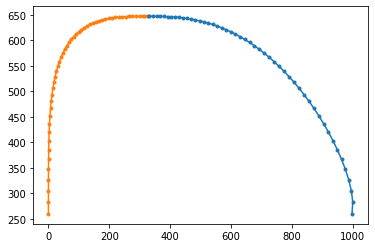

In [133]:
import numpy as np
import float_phi_functions
import scipy.optimize

# T_samples = np.linspace(260, iapws95_light.Tc - 0.5e-3, 200)
T_samples = iapws95_light.Tc - 0.5e-3 - (iapws95_light.Tc - 0.5e-3 - 260) * np.linspace(0,1,50)**3

psat, rho_satl, rho_satv = zip(*[[float_phi_functions.prho_sat(T)[key]
    for key in ["psat", "rho_satl", "rho_satv"]] for T in T_samples])

plt.plot(rho_satl, T_samples, '.-')
plt.plot(rho_satv, T_samples, '.-')

In [160]:
np.array([0.33333333, 0.66666667, 1.33333333, 3.0,
  6.16666667, 11.83333333])*6

array([ 1.99999998,  4.00000002,  7.99999998, 18.        , 37.00000002,
       70.99999998])

     fun: 0.8198484265245639
     jac: array([2.62792036e-02, 1.79707408e-02, 7.99557567e-03, 6.09025359e-04,
       5.51342964e-06, 2.23517418e-08, 4.76099998e-02])
 message: 'Optimization terminated successfully'
    nfev: 359
     nit: 41
    njev: 41
  status: 0
 success: True
       x: array([ 2.06655347e+00,  9.62104826e-01, -3.27564634e-01, -2.55287980e+00,
       -9.47890070e+00, -6.75614999e+05, -1.24029487e-02])


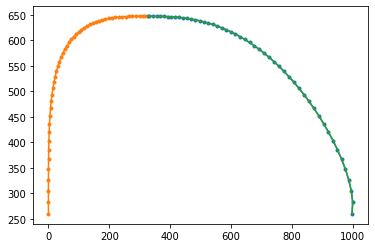

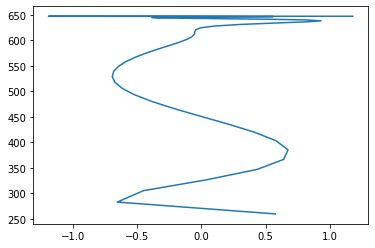

In [157]:
# Scale by input range for monomial terms
scaling = T_samples.max() - T_samples.min()
# Define fitting function
fit_func_incubed = lambda t: np.hstack([
  t,
  t**2,
  t**5,
  t**16,
  t**43,
  t**110,
  t**0.25,
  ])
fit_func = lambda t: fit_func_incubed(t**(1/3))

_name_size = fit_func(0).size

def func_repr(T, a):
  ''' Representation of rho at vector T '''
  # Call form of fitting function with shape manipulation
  return iapws95_light.rhoc * (1 + np.einsum("ij, j -> i",
    fit_func((1 - np.expand_dims(T, axis=1) / iapws95_light.Tc)), a))

def objective(a, y:np.array):
  ord = 8
  ''' Estimate of ||rho_approx - rho||_\infty '''
  return np.linalg.norm(func_repr(T_samples, a)\
    - y, ord=ord) / len(T_samples)**(1.0/ord)

# Set initial parameters
x_init = np.ones((_name_size,))
# x_init[0] = T_samples.mean()
x_init[0:6] = np.array([
  1.99206, 1.10123, -5.12506e-1, -1.75263, -45.4485, -6.75615e5])
# Optimize parameters
opt_obj = scipy.optimize.minimize(lambda a: objective(a, rho_satl),
  x_init, tol=1e-7, method="SLSQP")
# Print optimization result
print(opt_obj)

plt.plot(rho_satl, T_samples, '.-')
plt.plot(rho_satv, T_samples, '.-')
plt.plot(func_repr(T_samples, opt_obj.x), T_samples)
plt.figure()
plt.plot(func_repr(T_samples, opt_obj.x) - rho_satl, T_samples)

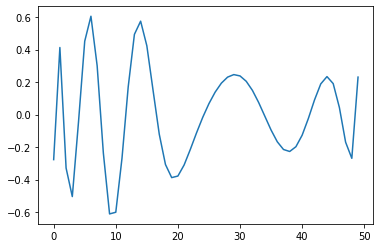

In [154]:
plt.plot(func_repr(T_samples, opt_obj.x) - rho_satl)

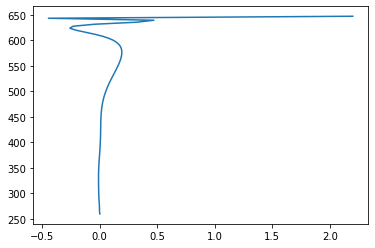

In [116]:
satl_powsb = np.array([
  1/3, 2/3, 5/3,
  16/3, 43/3, 110/3])
satl_coeffsb = np.array([
  1.99206, 1.10123, -5.12506e-1, -1.75263, -45.4485, -6.75615e5])

saulwa_satl = 1.0 + np.sum(satl_coeffsb \
  * np.expand_dims(1 - T_samples/iapws95_light.Tc,axis=-1) ** satl_powsb, axis=-1)
plt.plot(saulwa_satl*iapws95_light.rhoc - rho_satl, T_samples)

## Third derivative test

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import iapws95_light
import numpy as np

# Cython-backend imports
import float_phi_functions
import iapws95_light_perf

In [2]:
d = 838.025 / iapws95_light.rhoc
t = iapws95_light.Tc / 500
# float_phi_functions.fused_phir_d3(d, t), \
#   (float_phi_functions.phir_dd(d+1e-7, t)
#     - float_phi_functions.phir_dd(d-1e-7, t))/2e-7, \
#   float_phi_functions.phir_dd(d, t)

In [3]:
''' Setup error analysis functions'''
_eps = 1e-7
direct = lambda d, t: float_phi_functions.fused_phir_d3(d, t)["phir_ddd"]
approx_eps = lambda d, t, _eps: (float_phi_functions.phir_dd(d+0.5*_eps, t) - float_phi_functions.phir_dd(d-0.5*_eps, t))/_eps
approx = lambda d, t: approx_eps(d, t, _eps)
approx_rerr = lambda d, t: direct(d,t) / approx(d,t) - 1.0
approx_aerr = lambda d, t: direct(d,t) - approx(d,t)

In [4]:
''' Sample num. diff. vs. analytic ddd '''
t_range = np.linspace(1e-6, 2.0, 30)
d_range = np.linspace(1e-6, 2.3, 42)
mg_d, mg_t = np.meshgrid(d_range, t_range)
rerrs = np.array([approx_rerr(d, t) for d, t in zip(mg_d.ravel(), mg_t.ravel())])
aerrs = np.array([approx_aerr(d, t) for d, t in zip(mg_d.ravel(), mg_t.ravel())])

Text(0, 0.5, 't')

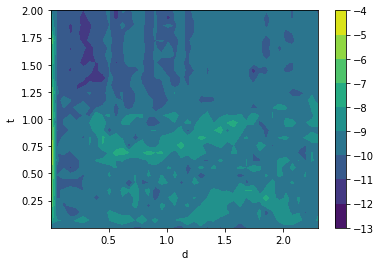

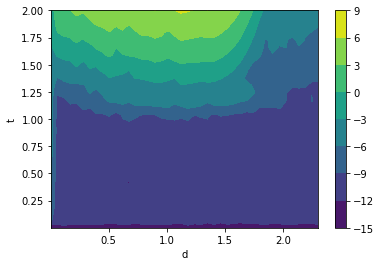

In [5]:
''' Show abs and rel errors '''
plt.figure()
plt.contourf(mg_d, mg_t, np.log10(np.reshape(np.abs(rerrs), mg_d.shape)))
plt.colorbar()
plt.xlabel("d")
plt.ylabel("t")

plt.figure()
plt.contourf(mg_d, mg_t, np.log10(np.reshape(np.abs(aerrs), mg_d.shape)))
plt.colorbar()
plt.xlabel("d")
plt.ylabel("t")

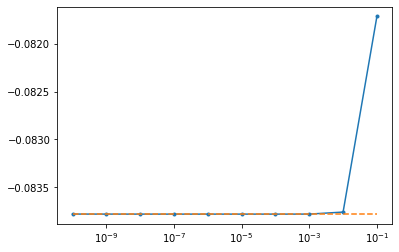

In [6]:
''' Point check of num diff convergence '''
check_val = direct(1.5, 1.01)
_e_vec = np.logspace(-10,-1,10)
plt.semilogx(_e_vec, [approx_eps(1.5, 1.01, e) for e in _e_vec], '.-')
plt.semilogx(_e_vec, check_val*np.ones_like(_e_vec), '--')

In [7]:
''' Verify Delta derivatives '''
def delta_series(d,t):
  d_quad = (d - 1.0)**2
  _c2 = d_quad ** (2.5) # d ** (a - 1)   TODO: use int pow
  _c1 = d_quad ** (2.0 / 3.0)
  _theta = (1.0 - t) + iapws95_light.A_res55_56[0] * _c1 * d_quad
  _Delta = _theta*_theta + iapws95_light.B_res55_56[0] * _c2 * d_quad

  _dDelta = (iapws95_light.A_res55_56[0] * _theta * 2.0 / iapws95_light.beta_res55_56[0] * _c1
    + 2.0 * iapws95_light.B_res55_56[0] * iapws95_light.a_res55_56[0] * _c2)
  # Compute second derivative of Delta
  _c3 = iapws95_light.A_res55_56[0] / iapws95_light.beta_res55_56[0] * _c1
  _ddDelta = _dDelta + (
    4.0 * iapws95_light.B_res55_56[0] * iapws95_light.a_res55_56[0] * (iapws95_light.a_res55_56[0] - 1.0) * _c2
    + 2.0 * _c3 * _c3 * d_quad
    + 4.0 * _theta * iapws95_light.A_res55_56[0] / iapws95_light.beta_res55_56[0] \
      * (iapws95_light._exp1_55_56[0] - 1.0) * _c1
  )
  if d - 1.0 == 0.0:
    _dddDelta = 0.0
  else:
    _dddDelta = (_ddDelta - _dDelta) / (d - 1.0) \
      + (
      4.0 * iapws95_light.B_res55_56[0] * iapws95_light.a_res55_56[0] * (iapws95_light.a_res55_56[0] - 1.0) \
        * 5.0 *_c2 / (d - 1.0) # unrolled d/dd (d_quad ** (a-1.0))
      + 2.0 * (iapws95_light.A_res55_56[0] / iapws95_light.beta_res55_56[0]) \
        * (iapws95_light.A_res55_56[0] / iapws95_light.beta_res55_56[0]) * _c1 * _c1 * (d - 1.0)\
        * (8.0 / 3.0 + 2.0)
      + 4.0 * (iapws95_light._exp1_55_56[0] - 1.0) * iapws95_light.A_res55_56[0] / iapws95_light.beta_res55_56[0] \
        * (
          (iapws95_light.A_res55_56[0] * (10.0 / 3.0) * _c1 * (d - 1.0)) * _c1
          + _theta * (4.0 / 3.0) * (_c1) / (d - 1.0)
        )
    )
  _dDelta *= d - 1.0
  return np.array([_Delta, _dDelta, _ddDelta, _dddDelta])

delta_series(1.5, 1.0)[1:], \
  ((delta_series(1.5+0.5e-7, 1.0) - delta_series(1.5-0.5e-7, 1.0))/1e-7)[:-1]

(array([0.03531416, 0.41481046, 4.04656425]),
 array([0.03531416, 0.41481046, 4.04656425]))

In [63]:
def get_terms(d, t):
  i = 54
  _Delta, _dDelta, _ddDelta, _dddDelta = delta_series(d, t)
  d_quad = (d - 1.0)**2.0
  a = _Delta*_Delta * (-4.0 * iapws95_light.C_res55_56[i-54] * (d-1.0) 
      + d * (2.0*iapws95_light.C_res55_56[i-54]*d_quad - 1.0) * 2.0 * iapws95_light.C_res55_56[i-54])
  b = _Delta * 2.0 * iapws95_light.b_res55_56[i-54] * _dDelta \
      * (1.0 - 2.0 * d * iapws95_light.C_res55_56[i-54] * (d - 1.0))
  c = iapws95_light.b_res55_56[i-54] * (_Delta * _ddDelta
      + (iapws95_light.b_res55_56[i-54] - 1.0) * _dDelta * _dDelta) * d
  return np.array([a,b,c])

In [85]:
def get_common(d, t):
  d_quad = (d - 1.0)**2
  return iapws95_light.n_res[i] * np.exp(-iapws95_light.C_res55_56[i-54] * d_quad \
  - iapws95_light.D_res55_56[i-54]*(t - 1.0)*(t - 1.0))

def get_c3(d, t):
  d_quad = (d - 1.0)**2
  _c2 = d_quad ** (2.5) # d ** (a - 1)   TODO: use int pow
  _c1 = d_quad ** (2.0 / 3.0)
  _theta = (1.0 - t) + iapws95_light.A_res55_56[0] * _c1 * d_quad
  _Delta = _theta*_theta + iapws95_light.B_res55_56[0] * _c2 * d_quad

  _dDelta = (iapws95_light.A_res55_56[0] * _theta * 2.0 / iapws95_light.beta_res55_56[0] * _c1
    + 2.0 * iapws95_light.B_res55_56[0] * iapws95_light.a_res55_56[0] * _c2)
  # Compute second derivative of Delta
  _c3 = iapws95_light.A_res55_56[0] / iapws95_light.beta_res55_56[0] * _c1
  _ddDelta = _dDelta + (
    4.0 * iapws95_light.B_res55_56[0] * iapws95_light.a_res55_56[0] * (iapws95_light.a_res55_56[0] - 1.0) * _c2
    + 2.0 * _c3 * _c3 * d_quad
    + 4.0 * _theta * iapws95_light.A_res55_56[0] / iapws95_light.beta_res55_56[0] \
      * (iapws95_light._exp1_55_56[0] - 1.0) * _c1
  )
  if d - 1.0 == 0.0:
    _dddDelta = 0.0
  else:
    _dddDelta = (_ddDelta - _dDelta) / (d - 1.0) \
      + (
      4.0 * iapws95_light.B_res55_56[0] * iapws95_light.a_res55_56[0] * (iapws95_light.a_res55_56[0] - 1.0) \
        * 5.0 *_c2 / (d - 1.0) # unrolled d/dd (d_quad ** (a-1.0))
      + 2.0 * (iapws95_light.A_res55_56[0] / iapws95_light.beta_res55_56[0]) \
        * (iapws95_light.A_res55_56[0] / iapws95_light.beta_res55_56[0]) * _c1 * _c1 * (d - 1.0)\
        * (8.0 / 3.0 + 2.0)
      + 4.0 * (iapws95_light._exp1_55_56[0] - 1.0) * iapws95_light.A_res55_56[0] / iapws95_light.beta_res55_56[0] \
        * (
          (iapws95_light.A_res55_56[0] * (10.0 / 3.0) * _c1 * (d - 1.0)) * _c1
          + _theta * (4.0 / 3.0) * (_c1) / (d - 1.0)
        )
    )
  _dDelta *= d - 1.0
  i = 54

  print("Check")
  print([_Delta, _dDelta, _ddDelta, _dddDelta])
  print(delta_series(d,t))

  _c3 = _Delta*_Delta * (-4.0 * iapws95_light.C_res55_56[i-54] * (d-1.0) 
    + d * (2.0*iapws95_light.C_res55_56[i-54]*d_quad - 1.0) * 2.0 * iapws95_light.C_res55_56[i-54])
  _c3 += _Delta * 2.0 * iapws95_light.b_res55_56[i-54] * _dDelta \
    * (1.0 - 2.0 * d * iapws95_light.C_res55_56[i-54] * (d - 1.0))
  _c3 += iapws95_light.b_res55_56[i-54] * (_Delta * _ddDelta
    + (iapws95_light.b_res55_56[i-54] - 1.0) * _dDelta * _dDelta) * d
  return _c3

## iapws95_light_perf testing

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import iapws95_light
import numpy as np

# Cython-backend imports
import float_phi_functions
import iapws95_light_perf

In [ ]:
# Test critical values
float_phi_functions.fused_phir_all(1,1)

In [ ]:
iapws95_light_perf.print_verification_values()

In [ ]:
d = 838.025 / iapws95_light.rhoc
t = iapws95_light.Tc / 500
float_phi_functions.fused_phir_d_phir_dd(d,t), float_phi_functions._fused_phir_d_phir_dd_clean(d,t) #, float_phi_functions.fused_phir_all(d,t)

In [ ]:
d = 358 / iapws95_light.rhoc
t = iapws95_light.Tc / 647
float_phi_functions.fused_phir_d_phir_dd(d,t), float_phi_functions._fused_phir_d_phir_dd_clean(d,t) #, float_phi_functions.fused_phir_all(d,t)

In [ ]:
''' Built-in timing '''
iapws95_light_perf.print_timing()

In [ ]:
''' Local timeit '''
print("Dummy with overhead only")
%timeit -n 10000 float_phi_functions._dummy(d, t)
print("phir_* (clean implementation)")
%timeit -n 10000 float_phi_functions._fused_phir_all_clean(d, t)
print("phir_* (opt implementation)")
%timeit -n 10000 float_phi_functions.fused_phir_all(d, t)
print("phir_d_phir_dd")
%timeit -n 10000 float_phi_functions.fused_phir_d_phir_dd(d, t)
print("phir_d_phir_dd")
%timeit -n 10000 float_phi_functions.fused_phir_d_phir_dd(d, t)
print("phir_* (opt implementation)")
%timeit -n 10000 float_phi_functions.fused_phir_all(d, t)
print("phir_* (clean implementation)")
%timeit -n 10000 float_phi_functions._fused_phir_all_clean(d, t)
print("Dummy with exp / power and overhead")
%timeit -n 10000 float_phi_functions._dummy_struct(d, t)
print("Dummy with overhead only")
%timeit -n 10000 float_phi_functions._dummy(d, t)

In [ ]:
''' Estimate % of op loads '''
import timeit
t_measure = timeit.timeit(lambda: float_phi_functions.fused_phir_all(d, t), number=10000)/10000
t_dummy_struct = timeit.timeit(lambda: float_phi_functions._dummy_struct(d, t), number=10000)/10000
t_dummy = timeit.timeit(lambda: float_phi_functions._dummy(d, t), number=10000)/10000
print(f"Estimate of pow/exp functions proportion: {(t_dummy_struct-t_dummy)/t_measure:.5f}")
print(f"Estimate of overhead proportion: {(t_dummy)/t_measure:.5f}")
print(f"Estimate of remaining code: {1 - t_dummy_struct/t_measure:.5f}")

In [2]:
print("Saturation curve evaluation")
%timeit -n 1000 float_phi_functions.prho_sat(400)
print("Mixed-phase pressure")
%timeit -n 1000 float_phi_functions.p(400, 400)
print("Mixed-phase energy")
%timeit -n 1000 float_phi_functions.u(400, 400)

print("Pure phase pressure (supercritical)")
%timeit -n 10000 float_phi_functions.p(400, 1000)
print("Pure phase energy (supercritical)")
%timeit -n 10000 float_phi_functions.u(400, 1000)

Saturation curve evaluation
251 µs ± 68.9 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
Mixed-phase pressure
189 µs ± 21.9 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
Mixed-phase energy
192 µs ± 5.47 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
Pure phase pressure (supercritical)
4.44 µs ± 438 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
Pure phase energy (supercritical)
5.86 µs ± 412 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [4]:
print("Low-precision saturation curve evaluation")
%timeit -n 10000 float_phi_functions.prho_sat_lowprec(400)

A
75.8 µs ± 6.41 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [6]:
float_phi_functions.prho_sat_lowprec(400), float_phi_functions.prho_sat(400)

({'psat': 245769.5945422318,
  'rho_satl': 937.486039520823,
  'rho_satv': 1.3694074418018012},
 {'psat': 245769.3455658411,
  'rho_satl': 937.4860393928047,
  'rho_satv': 1.369407541006816})

Text(0, 0.5, 'Sat vap density %err')

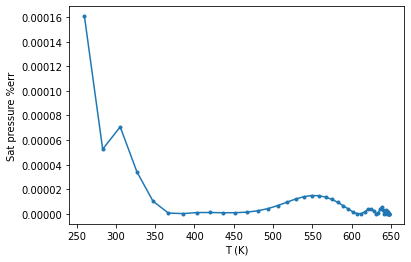

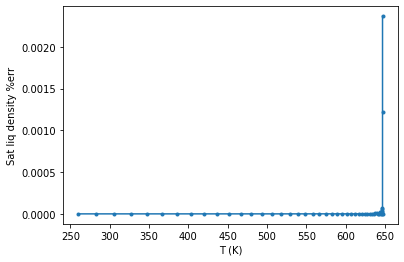

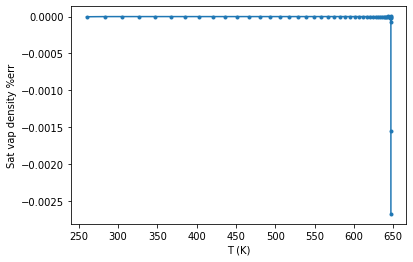

In [28]:
T_samples = iapws95_light.Tc - 0.5e-3 - (iapws95_light.Tc - 0.5e-3 - 260) * np.linspace(0,1,50)**3
psat_lp, rho_satl_lp, rho_satv_lp = np.array(list(zip(*
  [float_phi_functions.prho_sat_lowprec(T).values() for T in T_samples])))
psat_hp, rho_satl_hp, rho_satv_hp = np.array(list(zip(*
  [float_phi_functions.prho_sat(T).values() for T in T_samples])))
# float_phi_functions.prho_sat(400)
plt.figure()
plt.plot(T_samples, psat_lp/psat_hp-1.0, '.-')
plt.xlabel("T (K)")
plt.ylabel("Sat pressure %err")

plt.figure()
plt.plot(T_samples, rho_satl_lp/rho_satl_hp-1.0, '.-')
plt.xlabel("T (K)")
plt.ylabel("Sat liq density %err")

plt.figure()
plt.plot(T_samples, rho_satv_lp/rho_satv_hp-1.0, '.-')
plt.xlabel("T (K)")
plt.ylabel("Sat vap density %err")

In [17]:
float_phi_functions.prho_sat_lowprec(400).values()

dict_values([245769.5945422318, 937.486039520823, 1.3694074418018012])

In [23]:
np.array(list(zip(*
  [float_phi_functions.prho_sat_lowprec(T).values() for T in T_samples]))).shape

(3, 50)

In [ ]:
import pyXSteam.XSteam as XSteam
xsteam = XSteam.XSteam()
# Set test pressure (<100 MPa)
rho_test = 200
T_test = 1000
p_test_MPa = float_phi_functions.p(rho_test, T_test)/1e6
v_test = xsteam.v_pt(p_test_MPa, T_test)
rho_test, 1.0/v_test

In [ ]:
# Closest thing to (rho, T) -> p (no forward computation path is available).
%timeit -n 1000 xsteam.rho_pt(p_test, T_test)

In [ ]:
float_phi_functions.u(400, 1000), \
  float_phi_functions.u(400, 400)

In [ ]:
'''Test pressure function p(rho, T) (EOS)'''
rho_range = np.linspace(1, 1000, 256)
T_range = np.linspace(273, 1273, 128)
mg_T, mg_rho = np.meshgrid(T_range, rho_range)
mg_p = np.zeros_like(mg_T)
mg_u = np.zeros_like(mg_T)
for i, j in np.ndindex(mg_p.shape):
  mg_p[i,j] = float_phi_functions.p(mg_rho[i,j], mg_T[i,j])
  mg_u[i,j] = float_phi_functions.u(mg_rho[i,j], mg_T[i,j])

plt.contourf(mg_T, mg_rho, mg_p, levels=np.linspace(0, 1e8, 101))
plt.colorbar(label="Pressure (Pa)")
plt.contour(mg_T, mg_rho, mg_p,
  levels=[0.1e6, 4e6, 20e6, 24e6, 60e6, 240e6, 1000e6], colors="red")
plt.figure()
plt.contourf(mg_T, mg_rho, mg_u)
plt.colorbar(label="Energy (J/kg)")
print("Pressure scales up to 100 MPa; contours {0.1, 4, 20, 24, 60, 240, 1000} MPa to " +
  "compare with M. Chaplin (water.lsbu.ac.uk/water/water_density.html)")

In [ ]:
'''Test saturation curve computation'''
T_range = np.linspace(273, iapws95_light.Tc-1e-10, 100)
sats = [*map(float_phi_functions.prho_sat_stepinfo, T_range)]
psats, rhol, rhov, steps, res = zip(*sats)
res_norms = np.linalg.norm(np.array(res), axis=-1)
step_norms = np.linalg.norm(np.array(steps), axis=-1)
plt.semilogy(T_range, step_norms, '.-')
plt.semilogy(T_range, res_norms, '.-')
plt.legend(["Step size at n-1", "Residual at n"])
print("Last step size (2-norm) and residual of Maxwell residual (2-norm).")

In [ ]:
''' Compare analytic approx sat curve with Maxwell construction'''
# Saturated liquid density correlation (Eq. 2.3)
_powsb = np.array([1/3, 2/3, 5/3, 16/3, 43/3, 110/3])
_coeffsb = [1.99206, 1.10123, -5.12506e-1, -1.75263, -45.4485, -6.75615e5]
d_satl = lambda t: 1.0 + np.dot((1.0-1.0/t)**_powsb, _coeffsb)
# Saturated vapour density correlation (Eq. 2.2)
_powsc = np.array([1/3, 2/3, 4/3, 9/3, 37/6, 71/6])
_coeffsc = [-2.02957, -2.68781, -5.38107, -17.3151, -44.6384, -64.3486]
d_satv = lambda t: np.exp(np.dot((1.0-1.0/t)**_powsc, _coeffsc))

d_satl_approx = [d_satl(iapws95_light.Tc/T) for T in T_range]
d_satv_approx = [d_satv(iapws95_light.Tc/T) for T in T_range]

plt.plot(T_range, d_satl_approx, '--')
plt.plot(T_range, d_satv_approx, '--')
plt.plot(T_range, np.array(rhol) / iapws95_light.rhoc, '-')
plt.plot(T_range, np.array(rhov) / iapws95_light.rhoc, '-')
plt.title("Approximate and Maxwell saturation curves superimposed")
plt.figure()
plt.plot(T_range, d_satl_approx - np.array(rhol) / iapws95_light.rhoc, '--')
plt.ylabel("Diff d sat l")
plt.xlabel("T (K)")
plt.plot(T_range, d_satv_approx - np.array(rhov) / iapws95_light.rhoc, '--')
plt.ylabel("Diff d sat v")
plt.xlabel("T (K)")
plt.legend(["l", "v"])
plt.grid("both", "both")
plt.title("Difference in approx. and Maxwell saturation curves")

In [ ]:
''' psat - Tsat relationship '''
plt.plot(T_range, psats, '.-')
np.interp(iapws95_light.Tc, T_range, psats)
plt.xlabel("T (K)")
plt.ylabel("p (Pa)")

In [ ]:
# Printed result from iapws95_light.phir_tt(358/iapws95_light.rhoc, iapws95_light.Tc / 647)
z1 = [ 1.04472349e-02, -9.59990338e-01, -0.00000000e+00, -9.82559945e-02,
  6.05860380e-02,  2.51821854e-03,  0.00000000e+00, -2.93516306e+00,
  2.24339824e+00, -3.20137805e-03, -0.00000000e+00, -2.09177215e+00,
  8.72348190e-01, -4.03047444e-02,  3.09004634e-05, -3.05878278e-04,
  2.33177538e-03, -1.59981871e-04,  1.20649465e-07,  4.63477954e-06,
 -2.70141809e-10, -0.00000000e+00, -1.46532074e+00,  0.00000000e+00,
  5.72838269e+00, -1.30232914e+01,  2.08958096e+01,  1.33104875e-02,
 -5.85067353e-01, -2.97246153e+01,  2.12596432e+01,  3.38107678e-01,
 -6.74201148e+00,  7.79491623e-01,  0.00000000e+00, -4.38150357e-02,
  1.74736971e-01, -1.84592355e-01, -6.99666394e-02,  5.02206633e-02,
  9.58976961e-03, -9.51939245e-04,  3.64725467e+00,  6.26876729e+00,
 -1.50680115e+01,  4.89703207e+00, -5.40449307e-03, -2.85779055e-07,
 -1.08272029e+02,  1.89163001e+02, -8.34766580e+01, -1.66045467e+02,
  1.73093312e+02, -7.25941498e+00, -2.41084874e+00,  1.03600001e+00]
# Printed result from float_phi_functions.phir_tt(358/iapws95_light.rhoc, iapws95_light.Tc / 647)
z2 = [0.010447234835687661,
-0.9599903378384489,
-0.0,
-0.09825599433064153,
0.06058603807019969,
0.002518218544455502,
0.0,
-2.9351630561897437,
2.2433982442597364,
-0.0032013780447161786,
-0.0,
-2.091772145304223,
0.8723481903219628,
-0.04030474442317951,
3.090046336548172e-05,
-0.00030587827833254054,
0.0023317753858539164,
-0.00015998187100786356,
1.2064946503208344e-07,
4.6347795344888724e-06,
-2.7014180992736895e-10,
-0.0,
-1.4653207357712412,
0.0,
5.728382693436505,
-13.023291416324133,
20.89580962315094,
0.01331048750233531,
-0.5850673524083665,
-29.72461529211912,
21.259643161313537,
0.33810767772846967,
-6.742011470366356,
0.779491623310715,
0.0,
-0.04381503569465125,
0.17473697085933748,
-0.1845923551479196,
-0.06996663956715105,
0.05022066332634169,
0.00958976959560878,
-0.0009519392430030964,
3.647254669574024,
6.268767295120435,
-15.068011521512293,
4.897032062462177,
-0.005404493072474181,
-2.857790548589655e-07,
-108.27202963056544,
189.16300090570866,
-83.4766578353496,
-166.04546660332667,
173.09331149199872,
-7.259414970645418,
-2.410848753029746,
1.0360000148277766]

# Difference vector
import numpy as np 
import matplotlib.pyplot as plt
z1 = np.array(z1)
z2 = np.array(z2)
z1 - z2
plt.plot(z1-z2, '.')
plt.xlabel("Index")
plt.ylabel("Term diff")

plt.figure()
plt.semilogy(np.abs(z1-z2), '.')
plt.xlabel("Index")
plt.ylabel("Term diff")

plt.figure()
plt.semilogy(np.abs(1.0-z2/z1), '.')
plt.xlabel("Index")
plt.ylabel("Relative term diff")

print("Numerical noise (difference) between py and Cython implementations")

In [ ]:
import iapws95_light_perf
iapws95_light_perf.print_timing()

In [ ]:
import iapws95_light_perf
iapws95_light_perf.print_verification_values()

## Timing for mixtureWLM

In [ ]:
import line_profiler
import mixtureWLM
import matplotlib.pyplot as plt
import numpy as np

# f = mixtureWLM._itersolve_d
f = mixtureWLM.solve_rhow
profile = line_profiler.LineProfiler(f)
profile.runcall(f, 2000, 0.5, 350)
profile.print_stats()

In [ ]:
%timeit f(2000, 0.5, 350)

In [ ]:
''' Show (rho_mix, T, yw) -> rho_w calculations '''
print("With a mapping from (rho_mix, T, yw) -> rho_w, one can then compute " +
  "pressure from p(rho_w, T) or from pressure of the linearized magma given " +
  "v_m = v - yw * v_w. Note the weak dependence on T (outer iteration loop).")
for i, T in enumerate([273, 350, 550, 640, 650, 750]):
  plt.figure()
  vec_out_d = np.array([*map(lambda rho_mix, yw: mixtureWLM.solve_rhow(rho_mix, yw, T),
    mixtureWLM.mg_rho_mix.ravel(), mixtureWLM.mg_yw.ravel())])

  # Load vector data in ndarray
  mg_out_d = np.zeros_like(mixtureWLM.mg_yw)
  mg_out_steps = np.zeros_like(mixtureWLM.mg_yw)
  mg_out_d.ravel()[:] = vec_out_d.ravel()

  # Plot
  for i in range(mg_out_d.shape[0]):
    plt.plot(mixtureWLM.mg_rho_mix[i,:], mg_out_d[i,:].ravel(), '.-')
  xl = plt.xlabel("Mixture density (kg/m^3)")
  yl = plt.ylabel("Phasic density, water (kg/m^3)")
  plt.title(f"T = {T} K")
  plt.gca().set_aspect("equal")

## Feature Developement: Cython Atomics

In [ ]:
import iapws95_light
vectest_d, vectest_t = np.ones((1000,1)), np.ones((1000,1))
%timeit -n 20 iapws95_light.phir_d(vectest_d, vectest_t)

In [ ]:
import float_phi_functions
%timeit -n 20 [*map(float_phi_functions.phir_d, vectest_d.ravel(), vectest_t.ravel())]

In [ ]:
%timeit -n 20000 iapws95_light.phir_d(1.0, 1.0)
%timeit -n 20000 float_phi_functions.phir_d(1.0, 1.0)

In [ ]:
# Value check
import iapws95_light
import float_phi_functions
iapws95_light.phir_d(1.0, 1.0), float_phi_functions.phir_d(1.0, 1.0), \
  iapws95_light.phir_dd(1.0, 1.0), float_phi_functions.phir_dd(1.0, 1.0), \
  iapws95_light.phir_d(0.7, 0.3), float_phi_functions.phir_d(0.7, 0.3), \
  iapws95_light.phir_dd(0.7, 0.3), float_phi_functions.phir_dd(0.7, 0.3), \
  float_phi_functions.fused_phir_d_phir_dd(1.0, 1.0), \
  float_phi_functions.fused_phir_d_phir_dd(0.7, 0.3),

In [ ]:
%timeit -n 10000 float_phi_functions._dummy(0.7, 0.3)
%timeit -n 10000 float_phi_functions.phir_d(0.7, 0.3)
%timeit -n 10000 float_phi_functions.phir_dd(0.7, 0.3)
%timeit -n 10000 float_phi_functions.fused_phir_d_phir_dd(0.7, 0.3)
%timeit -n 1000 iapws95_light.phir_d(0.7, 0.3)
%timeit -n 1000 iapws95_light.phir_dd(0.7, 0.3)

In [ ]:
# Overhead measurement
%timeit -n 500000 float_phi_functions._dummy(0.7, 0.3)

In [ ]:
''' Extract table from _ndtc '''
# np.set_printoptions(linewidth=60)
# _ndtc.reshape((51,4))[:,0:3].ravel().shape

In [ ]:
''' Single-precision testing (legacy)'''
import single_phi_functions
single_phi_functions.fused_phir_d_phir_dd(1.0, 1.0), \
  single_phi_functions.fused_phir_d_phir_dd(0.7, 0.3),
%timeit -n 10000 single_phi_functions.phir_dd(0.7, 0.3)

In [ ]:
''' Verification values for Cython implementaiton '''
import iapws95_light_perf
iapws95_light_perf.print_verification_values()

## Profiling (profiling Cython is wonky)

In [ ]:
import cProfile
cProfile.run('float_phi_functions.fused_phir_d_phir_dd(0.7, 0.3)')

In [ ]:
# %load_ext line_profiler

import line_profiler
import float_phi_functions
profile = line_profiler.LineProfiler(float_phi_functions.fused_phir_d_phir_dd)
profile.runcall(float_phi_functions.fused_phir_d_phir_dd, 0.7, 0.3)
profile.print_stats()


In [ ]:
import pstats, cProfile
cProfile.runctx("float_phi_functions.fused_phir_d_phir_dd(0.7, 0.3)",
  globals(), locals(), "Profile.prof")

s = pstats.Stats("Profile.prof")
s.strip_dirs().sort_stats("time").print_stats()

In [ ]:
def test2(x, y):
  return float_phi_functions.fused_phir_d_phir_dd(x, y)

In [ ]:
profile = line_profiler.LineProfiler(test2)
profile.runcall(test2, 0.7, 0.3)
profile.print_stats()

In [ ]:
dir(profile)

In [ ]:
%load_ext line_profiler
import float_phi_functions
import IPython.core
IPython.core.page = print

In [ ]:
%lprun -f float_phi_functions.fused_phir_d_phir_dd float_phi_functions.fused_phir_d_phir_dd(0.7, 0.3)

## Feature Development: Saturation Curve

In [ ]:
# Saul and Wagner 1987

# Context: (rho, T) -> p_sat by Maxwell construction
t = iapws95_light.Tc / T_ref
rho = rho_ref

# Saturated liquid density correlation (2.3)
_powsb = np.array([1/3, 2/3, 5/3, 16/3, 43/3, 110/3])
_coeffsb = [1.99206, 1.10123, -5.12506e-1, -1.75263, -45.4485, -6.75615e5]
d1 = 1.0 + np.dot((1.0-1.0/t)**_powsb, _coeffsb)
# Saturated vapour density correlation (2.2)
_powsc = np.array([1/3, 2/3, 4/3, 9/3, 37/6, 71/6])
_coeffsc = [-2.02957, -2.68781, -5.38107, -17.3151, -44.6384, -64.3486]
d2 = np.exp(np.dot((1.0-1.0/t)**_powsc, _coeffsc))

# Define size-2 system for d-bounds on phase transition (Maxwell construction)
phir_d = lambda d: iapws95_light.phir_d(d, t)
phir = lambda d: iapws95_light.phir(d, t)
phi0 = lambda d: iapws95_light.phi0(d, t)
eq1 = lambda d1, d2: d2 * phir_d(d2) - d1 * phir_d(d1) - phir(d1) - phi0(d1) +phir(d2) + phi0(d2)
eq2 = lambda d1, d2: d1 + d1**2 * phir_d(d1) - d2 - d2**2 * phir_d(d2)
eqvec = lambda d: np.array([eq1(d[0], d[1]), eq2(d[0], d[1])]).squeeze()

# Solve system using fsolve, initial guess using older sat curve correlations
import scipy.optimize
d_init = np.array([d1, d2])
d_final = scipy.optimize.fsolve(eqvec, d_init)
print("Init, final, residuals:")
print(d_init, d_final, eqvec(d_final))

# Get saturation densities at given T
rho_l, rho_v = d_final * iapws95_light.rhoc

# Use either for saturation pressure
psat = d_final[0]*(1.0 + d_final[0]*iapws95_light.phir_d(d_final[0], t)) \
  * iapws95_light.rhoc * iapws95_light.R * T_ref
# p = d_final[1]*(1.0 + d_final[1]*iapws95_light.phir_d(d_final[1], t)) \
  # * iapws95_light.rhoc * iapws95_light.R * T_ref
p = psat
print(f"psat = {psat}")

# context: 
if rho <= rho_l and rho >= rho_v:
  # Return saturation pressure
  print(f"Mixture")
elif rho < rho_v:
  rho = rho_v/iapws95_light.rhoc
else:
  rho = rho_l/iapws95_light.rhoc

In [ ]:
# Saturation pressure recovery check
d_final[0]*(1.0 + d_final[0]*iapws95_light.phir_d(d_final[0], t)) * iapws95_light.rhoc * iapws95_light.R * T_ref, \
  d_final[1]*(1.0 + d_final[1]*iapws95_light.phir_d(d_final[1], t)) * iapws95_light.rhoc * iapws95_light.R * T_ref

In [ ]:
# Get rho bounds given T
rho_bounds = d_final * iapws95_light.rhoc
rho_l = rho_bounds[0]
rho_v = rho_bounds[1]
# Context: (p, T) -> rho
rho = rho_ref

# Use either for saturation pressure
psat = d_final[0]*(1.0 + d_final[0]*iapws95_light.phir_d(d_final[0], t)) \
  * iapws95_light.rhoc * iapws95_light.R * T_ref
# p = d_final[1]*(1.0 + d_final[1]*iapws95_light.phir_d(d_final[1], t)) \
  # * iapws95_light.rhoc * iapws95_light.R * T_ref
p = psat
print(f"psat = {psat}")

if rho <= rho_l and rho >= rho_v:
  # Return saturation pressure
  print(f"Mixture")
elif rho < rho_v:
  rho = rho_v/iapws95_light.rhoc
else:
  rho = rho_l/iapws95_light.rhoc

print(d)
for i in range(5):
  val = - p / (iapws95_light.rhoc * iapws95_light.R * T_ref) + d + d **2 * iapws95_light.phir_d(d, t)
  deriv = 1 + 2 * d * iapws95_light.phir_d(d, t) + d**2 * iapws95_light.phir_dd(d, t)
  d -= val / deriv
  print(d)
print(d * iapws95_light.rhoc)

## Structure development

In [ ]:
import csv
import numpy as np

''' Data loading ''' 

DATAPATH_IDEAL = 'ideal.csv'
DATAPATH_RES0 = 'residual_1_51.csv'
DATAPATH_RES1 = 'residual_52_54.csv'
DATAPATH_RES2 = 'residual_55_56.csv'

with open(DATAPATH_IDEAL, newline='') as csvfile:
  reader = csv.DictReader(csvfile, delimiter='\t')
  ideal_arraydict = [row for row in reader]

with open(DATAPATH_RES0, newline='') as csvfile:
  reader = csv.DictReader(csvfile, delimiter='\t')
  residual0_arraydict = [row for row in reader]

with open(DATAPATH_RES1, newline='') as csvfile:
  reader = csv.DictReader(csvfile, delimiter='\t')
  residual1_arraydict = [row for row in reader]

with open(DATAPATH_RES2, newline='') as csvfile:
  reader = csv.DictReader(csvfile, delimiter='\t')
  residual2_arraydict = [row for row in reader]

''' Data prep '''
n_ideal = np.array([float(obj["n_i"]) for obj in ideal_arraydict])
g_ideal = np.array([float(obj["g_i"]) for obj in ideal_arraydict])

# Compile shared residual coefficients
n_res = np.hstack(([float(obj["n_i"]) for obj in residual0_arraydict],
  [float(obj["n_i"]) for obj in residual1_arraydict],
  [float(obj["n_i"]) for obj in residual2_arraydict]))
d_res = np.hstack(([float(obj["d_i"]) for obj in residual0_arraydict],
  [float(obj["d_i"]) for obj in residual1_arraydict],
  [1.0 for obj in residual2_arraydict]))
t_res = np.hstack(([float(obj["t_i"]) for obj in residual0_arraydict],
  [float(obj["t_i"]) for obj in residual1_arraydict],
  [0.0 for obj in residual2_arraydict]))

c_res1_51 = np.array([float(obj["c_i"]) for obj in residual0_arraydict])

c_res52_54 = np.array([float(obj["c_i"]) for obj in residual1_arraydict])
alpha_res52_54 = np.array([float(obj["alpha_i"]) for obj in residual1_arraydict])
beta_res52_54 = np.array([float(obj["beta_i"]) for obj in residual1_arraydict])
gamma_res52_54 = np.array([float(obj["gamma_i"]) for obj in residual1_arraydict])
eps_res52_54 = np.array([float(obj["eps_i"]) for obj in residual1_arraydict])

a_res55_56 = np.array([float(obj["a_i"]) for obj in residual2_arraydict])
b_res55_56 = np.array([float(obj["b_i"]) for obj in residual2_arraydict])
B_res55_56 = np.array([float(obj["B_i"]) for obj in residual2_arraydict])
C_res55_56 = np.array([float(obj["C_i"]) for obj in residual2_arraydict])
D_res55_56 = np.array([float(obj["D_i"]) for obj in residual2_arraydict])
A_res55_56 = np.array([float(obj["A_i"]) for obj in residual2_arraydict])
beta_res55_56 = np.array([float(obj["beta_i"]) for obj in residual2_arraydict])

''' Set up static parameters '''
Tc = 647.096  # K
rhoc = 322    # kg / m^3
R = 0.46151805 # kJ / kg K
# Generic precomputation
_exp1_55_56 = 0.5 / (beta_res55_56)

In [ ]:
''' Simulate input '''
rho = 838.025
T = 500

rho = 358
T = 647

In [ ]:
''' Compute reduced variables '''

# Reciprocal reduced volume
d = rho / rhoc
# Reciprocal reduced temperature
t = Tc / T

In [ ]:
def phi(d, t):
  ''' Reduced Helmholtz function f/(RT). ''' 

  # Scalar precomputation
  d_quad = (d-1.0)**2

  ''' Ideal-gas part of Helmholtz function f '''
  phi0 = np.log(d) + n_ideal[0] + n_ideal[1] * t + n_ideal[2] * np.log(t)
  phi0 += np.dot(n_ideal[3:8], np.log(1.0 - np.exp(-g_ideal[3:8] * t)))

  ''' Residual part of Helmholtz function f
  Evaluated using two registers that combine as
    np.dot( coeffs, np.exp(exponents) ).
  '''
  # Allocate exponent cache
  exponents = np.zeros_like(n_res)
  # Allocate and evaluate coeffs
  coeffs = n_res * (d ** d_res) * (t ** t_res)

  # Compute distance term for 1-indices 55 to 56
  theta = (1 - t) + A_res55_56 * d_quad ** _exp1_55_56
  Delta = theta**2 + B_res55_56 * d_quad ** a_res55_56
  # Factor in Delta**b_i term for 1-indices from 55 to 56
  coeffs[54:56] *= Delta ** b_res55_56

  # Compute exponents for 1-indices 8 to 51 as -d**c_i
  exponents[7:51] = -d ** c_res1_51[7:51]
  # Compute exponents for 1-indices from 52 to 54
  exponents[51:54] = -alpha_res52_54 * (d - eps_res52_54) ** 2 \
    -beta_res52_54*(t - gamma_res52_54)**2
  # Compute exponents for 1-indices from 55 to 56
  exponents[54:56] = -C_res55_56 * d_quad \
    -D_res55_56*(t - 1)**2

  # Compute residual part of reduced Helmholtz
  phir = np.dot(coeffs, np.exp(exponents))

  return (phi0, phir)

def Z(d, t):
  ''' Compressibility factor evaluation
  The compressibility factor Z is given by
    Z == p * v / (R * T) = 1 + delta * d(phi_R)/d(delta),
  where d(phi_R)/d(delta) is the partial derivative of the residual
  part of the reduced Helmholtz function, with respect to d = rho/rhoc.
  Evaluated using two registers that combine as
    np.dot( coeffs, np.exp(exponents) ).
  '''

  # Scalar precomputation
  d_quad = (d-1)**2

  # Allocate exponent cache
  exponents = np.zeros_like(n_res)
  # Allocate and partially evaluate coeffs
  coeffs = n_res * (d ** (d_res-1)) * (t ** t_res)
  # Factor in d_i - c_i * d**c_i term
  coeffs[0:51] *= (d_res[0:51] - c_res1_51 * d ** c_res1_51)
  coeffs[51:54] *= d_res[51:54] - 2.0 * alpha_res52_54 * d * (d - eps_res52_54)

  # Compute distance term for 1-indices 55 to 56
  theta = (1 - t) + A_res55_56 * d_quad ** _exp1_55_56
  Delta = theta**2 + B_res55_56 * d_quad ** a_res55_56
  # Factor in other terms for 1-indices from 55 to 56 in two steps
  coeffs[54:56] *= (
    Delta * (1.0 - 2.0 * C_res55_56 * (d-1.0) * d)
    + b_res55_56 * d * (d-1.0) * (
      A_res55_56 * theta * 2 / beta_res55_56 * d_quad**(_exp1_55_56 - 1.0)
      + 2 * B_res55_56 * a_res55_56 * d_quad**(a_res55_56 - 1.0)
    )
  )
  coeffs[54:56] *= Delta ** np.where(Delta != 0, b_res55_56-1, 1.0)

  # Compute exponents for 1-indices 8 to 51 as -d**c_i
  exponents[7:51] = -d ** c_res1_51[7:51]
  # Compute exponents for 1-indices from 52 to 54
  exponents[51:54] = -alpha_res52_54 * (d - eps_res52_54) ** 2 \
    -beta_res52_54*(t - gamma_res52_54)**2
  # Compute exponents for 1-indices from 55 to 56
  exponents[54:56] = -C_res55_56 * d_quad \
    -D_res55_56*(t - 1)**2

  # Reduce
  phir_d = np.dot(coeffs, np.exp(exponents))
  return 1 + d * phir_d


In [ ]:
''' Compute reduced variables '''
# Reciprocal reduced volume
d = rho / rhoc
# Reciprocal reduced temperature
t = Tc / T

# phi, phir_d, Z
print(f"phi0 = {phi(d, t)[0]:.8f}, phir = {phi(d, t)[1]:.8f}, phir_d = {(Z(d, t) - 1)/d:.9f}")

# Print verification values
verification_string = '''
For T = 647 K, rho = 358 kg m^{-3}:
phi0 = -1.56319605
phir = -1.21202657
phir_d = -0.714012024
'''
print(verification_string)


In [ ]:
from time import perf_counter

print(f"Timing p(rho, T) calculations.")
# Timing for pressure evaluation
N_timing = 25000
t1 = perf_counter()
for i in range(N_timing):
  p = Z(rho / rhoc, Tc / T) * rho * R * T
t2 = perf_counter()

t1_ideal = perf_counter()
for i in range(N_timing):
  p_ideal = rho * R * T
t2_ideal = perf_counter()

print(f"IAPWS95 light: {(t2-t1)/N_timing * 1e3} ms")
print(f"Ideal gas    : {(t2_ideal-t1_ideal)/N_timing * 1e3} ms")
print(f"Relative load: {(t2-t1)/(t2_ideal-t1_ideal):.3f}x")

num_coeffs = 44*4 + 21 + 21 + 16 + 13
print(f"=== Additional details ===")
print(f"Number of coefficients in model: {num_coeffs}")
print(f"Relative load per model dof:     {(t2-t1)/(t2_ideal-t1_ideal)/num_coeffs:.3f}x")

In [ ]:
def phi0_t(d, t):
  ''' Ideal-gas part of Helmholtz function f '''
  phi0 = n_ideal[1] + n_ideal[2] / t
  phi0 += np.expand_dims(np.einsum("i, ...i -> ...", n_ideal[3:8] * g_ideal[3:8],
    1.0/(1.0 - np.exp(-g_ideal[3:8] * t)) - 1.0), axis=-1)

  # Reduce
  return phi0

def phir_t(d, t):
  ''' Derivative of reduced Helmholtz function with respect to recip. reduced
  temperature.
  '''

  # Scalar precomputation
  d_quad = (d-1)**2
  # Allocate and partially evaluate coeffs
  coeffs = n_res * (d ** d_res) * (t ** (t_res-1.0))
  # Factor for 1-indices 1 to 51
  coeffs[...,0:51] *= t_res[0:51]
  # Factor in d_i - c_i * d**c_i term for 1-indices 52 to 54
  coeffs[...,51:54] *= t_res[51:54] - 2.0 * beta_res52_54 * t * (t - gamma_res52_54)

  # Compute distance term for 1-indices 55 to 56
  theta = (1 - t) + A_res55_56 * d_quad ** _exp1_55_56
  Delta = theta**2 + B_res55_56 * d_quad ** a_res55_56
  # Replace (t_res is zero, so coeffs[54:56] contains invalid entries) for
  #   1-indices from 55 to 56 in two steps
  coeffs[...,54:56] = n_res[54:56] * d * 2.0 * (
    -theta * b_res55_56 + Delta * D_res55_56 * (1.0 - t))
  coeffs[...,54:56] *= Delta ** np.where(Delta != 0, b_res55_56-1, 1.0)

  # Allocate exponent cache
  exponents = np.zeros_like(coeffs)
  # Compute exponents for 1-indices 8 to 51 as -d**c_i
  exponents[...,7:51] = -d ** c_res1_51[7:51]
  # Compute exponents for 1-indices from 52 to 54
  exponents[...,51:54] = -alpha_res52_54 * (d - eps_res52_54) ** 2 \
    -beta_res52_54*(t - gamma_res52_54)**2
  # Compute exponents for 1-indices from 55 to 56
  exponents[...,54:56] = -C_res55_56 * d_quad \
    -D_res55_56*(t - 1)**2

  # Reduce
  return np.expand_dims(np.einsum("...i, ...i -> ...",
    coeffs, np.exp(exponents)), axis=-1)

In [ ]:
phi0_t(d, t), 0.980_343_918e1, phir_t(d, t), -0.321_722_501e1

In [ ]:
_input = np.tile(np.array([t]), (10,1))
_input.shape

In [ ]:
phir_t(np.tile(np.array([d]), (10,1)), np.tile(np.array([t]), (10,1)))
phir_t(d, t)

In [ ]:
_exp1_55_56

In [ ]:
def phir_dd(d, t):
  ''' Second derivative dd of reduced Helmholtz function with respect to recip. reduced
  temperature.
  '''

  # Scalar precomputation
  d_quad = (d-1)**2
  # Allocate and partially evaluate coeffs
  coeffs = n_res * (d ** (d_res-2.0)) * (t ** t_res)
  # Temporary space
  cdc = c_res1_51 * (d ** c_res1_51)
  # Factor for 1-indices 1 to 51
  coeffs[...,0:51] *= (d_res[0:51] - cdc) * (d_res[0:51] - 1.0 - cdc) \
    - c_res1_51 * cdc
  # Factor for 1-indices 52 to 54
  coeffs[...,51:54] *= -2 * alpha_res52_54 * d**2 \
    + 4 * alpha_res52_54**2 * d**2 * (d - eps_res52_54)**2 \
    - 4 * d_res[51:54] * alpha_res52_54 * d * (d - eps_res52_54) \
    + d_res[51:54] * (d_res[51:54] - 1.0)

  # Compute distance term for 1-indices 55 to 56
  theta = (1.0 - t) + A_res55_56 * d_quad ** _exp1_55_56
  Delta = theta**2 + B_res55_56 * d_quad ** a_res55_56
  # Compute d(Delta)/d(delta) divided by (delta - 1.0)
  dDelta_div = (
    A_res55_56 * theta * 2.0 / beta_res55_56 * d_quad**(_exp1_55_56 - 1.0)
    + 2 * B_res55_56 * a_res55_56 * d_quad**(a_res55_56 - 1.0)
  )
  # Set power to non-negative when argument is negative
  limited_power = np.where(d_quad != 0, _exp1_55_56 - 2.0, 1.0)
  ddDelta = dDelta_div + ((d-1.0)**2) * (
    4.0 * B_res55_56 * a_res55_56 * (a_res55_56 - 1.0)
    * d_quad**(a_res55_56 - 2.0)
    + 2.0 * (A_res55_56 / beta_res55_56 * d_quad**(_exp1_55_56 - 1.0))**2.0
    + 4.0 * theta * A_res55_56 / beta_res55_56 * (_exp1_55_56 - 1.0)
    * d_quad**limited_power
  )
  # Finish d(Delta)/d(delta) computation
  dDelta = (d-1.0) * dDelta_div
  # Replace (t_res is zero, so coeffs[54:56] contains invalid entries) for
  #   1-indices from 55 to 56
  coeffs[...,54:56] = Delta**2 * (-4 * C_res55_56 * (d-1.0) 
    + d * (2*C_res55_56*d_quad - 1.0) * 2.0 * C_res55_56)
  coeffs[...,54:56] += Delta * 2.0 * b_res55_56 * dDelta \
    * (1.0 - 2.0 * d * C_res55_56 * (d - 1.0))
  coeffs[...,54:56] += b_res55_56 * (Delta * ddDelta
    + (b_res55_56 - 1.0) * dDelta**2) * d
  coeffs[...,54:56] *= n_res[54:56] \
    * Delta ** np.where(Delta != 0, b_res55_56 - 2.0, 1.0)

  # Allocate exponent cache
  exponents = np.zeros_like(coeffs)
  # Compute exponents for 1-indices 8 to 51 as -d**c_i
  exponents[...,7:51] = -cdc[7:51] / c_res1_51[7:51]
  # Compute exponents for 1-indices from 52 to 54
  exponents[...,51:54] = -alpha_res52_54 * (d - eps_res52_54) ** 2 \
    -beta_res52_54*(t - gamma_res52_54)**2
  # Compute exponents for 1-indices from 55 to 56
  exponents[...,54:56] = -C_res55_56 * d_quad \
    -D_res55_56*(t - 1.0)**2

  # Reduce
  return np.expand_dims(np.einsum("...i, ...i -> ...",
    coeffs, np.exp(exponents)), axis=-1)

def phir_dt(d, t):
  ''' Second derivative dt of reduced Helmholtz function with respect to recip. reduced
  temperature.
  '''

  # Scalar precomputation
  d_quad = (d-1)**2
  # Allocate and partially evaluate coeffs
  coeffs = n_res * (d ** (d_res-1.0)) * (t ** (t_res-1.0))
  dc = d ** c_res1_51
  # Factor for 1-indices 1 to 51
  coeffs[...,0:51] *= t_res[0:51] * (d_res[0:51] - c_res1_51 * dc)
  # Factor for 1-indices 52 to 54
  coeffs[...,51:54] *= d_res[51:54] - 2.0 * alpha_res52_54 * d * (d - eps_res52_54)
  coeffs[...,51:54] *= t_res[51:54] - 2.0 * beta_res52_54 * t * (t - gamma_res52_54)

  # Compute distance term for 1-indices 55 to 56
  theta = (1 - t) + A_res55_56 * d_quad ** _exp1_55_56
  Delta = theta**2 + B_res55_56 * d_quad ** a_res55_56
  # Compute d(Delta)/d(delta)
  dDelta = (d-1.0) * (
    A_res55_56 * theta * 2.0 / beta_res55_56 * d_quad**(_exp1_55_56 - 1.0)
    + 2.0 * B_res55_56 * a_res55_56 * d_quad**(a_res55_56 - 1.0)
  )
  # Replace (t_res is zero, so coeffs[54:56] contains invalid entries) for
  #   1-indices from 55 to 56 in two steps
  coeffs[...,54:56] = n_res[54:56] * (
    Delta**2 * (-2.0 * D_res55_56 * (t - 1.0) + d * 4.0 * C_res55_56 *
    D_res55_56 * (d - 1.0) * (t - 1.0))
    + d * Delta * b_res55_56 * dDelta * (-2.0 * D_res55_56 * (t - 1.0))
    - 2.0 * theta * b_res55_56 * Delta * (1.0 - 2.0*d*C_res55_56*(d - 1.0))
    + d * (
      -A_res55_56 * b_res55_56 * 2.0 / beta_res55_56 * Delta * (d - 1.0)
      * d_quad ** (_exp1_55_56 - 1.0)
      - 2.0 * theta * b_res55_56 * (b_res55_56 -1.0) * dDelta
    )
  )
  coeffs[...,54:56] *= Delta ** np.where(Delta != 0, b_res55_56 - 2.0, 1.0)

  # Allocate exponent cache
  exponents = np.zeros_like(coeffs)
  # Compute exponents for 1-indices 8 to 51 as -d**c_i
  exponents[...,7:51] = -dc[7:51]
  # Compute exponents for 1-indices from 52 to 54
  exponents[...,51:54] = -alpha_res52_54 * (d - eps_res52_54) ** 2 \
    -beta_res52_54*(t - gamma_res52_54)**2
  # Compute exponents for 1-indices from 55 to 56
  exponents[...,54:56] = -C_res55_56 * d_quad \
    -D_res55_56*(t - 1.0)**2

  # Reduce
  return np.expand_dims(np.einsum("...i, ...i -> ...",
    coeffs, np.exp(exponents)), axis=-1)

def phir_tt(d, t):
  ''' Second derivative tt of reduced Helmholtz function with respect to recip. reduced
  temperature.
  '''

  # Scalar precomputation
  d_quad = (d-1)**2
  # Allocate and partially evaluate coeffs
  coeffs = n_res * (d ** d_res) * (t ** (t_res-2.0))
  # Factor for 1-indices 1 to 51
  coeffs[...,0:51] *= t_res[0:51] * (t_res[0:51] - 1.0)
  # Factor for 1-indices 52 to 54
  coeffs[...,51:54] *= (t_res[51:54] - 2.0 * beta_res52_54 * t * 
    (t - gamma_res52_54))**2 - t_res[51:54] - 2.0 * beta_res52_54 * t**2

  # Compute distance term for 1-indices 55 to 56
  theta = (1.0 - t) + A_res55_56 * d_quad ** _exp1_55_56
  Delta = theta**2 + B_res55_56 * d_quad ** a_res55_56
  # Replace (t_res is zero, so coeffs[54:56] contains invalid entries) for
  #   1-indices from 55 to 56 in two steps
  coeffs[...,54:56] = n_res[54:56] * d * (
    2.0 * b_res55_56 * (Delta + 2.0 * theta**2 * (b_res55_56 - 1.0)
    + 4.0 * theta * Delta * D_res55_56 * (t - 1.0))
    + Delta ** 2 * 2.0 * D_res55_56 * (2.0*D_res55_56 * (t - 1.0)**2 - 1.0)
  )
  coeffs[...,54:56] *= Delta ** np.where(Delta != 0, b_res55_56 - 2.0, 1.0)
  # Set phir_tt at rho == 1 to -inf gracefully
  coeffs[...,54:56] = np.where(Delta != 0, coeffs[...,54:56], -np.inf)

  # Allocate exponent cache
  exponents = np.zeros_like(coeffs)
  # Compute exponents for 1-indices 8 to 51 as -d**c_i
  exponents[...,7:51] = -d ** c_res1_51[7:51]
  # Compute exponents for 1-indices from 52 to 54
  exponents[...,51:54] = -alpha_res52_54 * (d - eps_res52_54) ** 2 \
    -beta_res52_54*(t - gamma_res52_54)**2
  # Compute exponents for 1-indices from 55 to 56
  exponents[...,54:56] = -C_res55_56 * d_quad \
    -D_res55_56*(t - 1.0)**2

  # Reduce
  return np.expand_dims(np.einsum("...i, ...i -> ...",
    coeffs, np.exp(exponents)), axis=-1)

In [ ]:
b_res55_56[0] * (2.0 * Delta +
  4.0 * theta ** 2 * (b_res55_56[0] - 1.0))

In [ ]:
2.0 * b_res55_56[0] * Delta, \
  4.0 * theta ** 2 * b_res55_56[0] * (b_res55_56[0] - 1.0), \
  8.0 * theta * b_res55_56[0] * Delta * D_res55_56[0] * (t - 1.0), \
  Delta ** 2 * 2.0 * D_res55_56[0] * (2.0*D_res55_56[0] * (t - 1.0)**2 - 1.0), \
  n_res[54] * d * Delta ** (b_res55_56[0] - 2.0) * np.exp(-C_res55_56[0] * d_quad \
    -D_res55_56[0]*(t - 1.0)**2)


In [ ]:
d, t = 1.0-1e-10, 1.05
d_quad = (d-1.0)**2
theta = (1.0 - t) + A_res55_56[0] * d_quad ** _exp1_55_56[0]
Delta = theta**2 + B_res55_56[0] * d_quad ** a_res55_56[0]
n_res[54] * d * (
    2.0 * b_res55_56[0] * Delta
    + 4.0 * theta ** 2 * b_res55_56[0] * (b_res55_56[0] - 1.0)
    + 8.0 * theta * b_res55_56[0] * Delta * D_res55_56[0] * (t - 1.0)
    + Delta ** 2 * 2.0 * D_res55_56[0] * (2.0*D_res55_56[0] * (t - 1.0)**2 - 1.0)
  ) * Delta ** (b_res55_56[0] - 2.0) * np.exp(-C_res55_56[0] * d_quad \
    -D_res55_56[0]*(t - 1.0)**2)
    
    
    
    # , Delta ** (b_res55_56[0] - 2.0), np.exp(-C_res55_56[0] * d_quad \
    # -D_res55_56[0]*(t - 1.0)**2)

In [ ]:
rhoc

In [ ]:
-R*phir_tt(321.999/rhoc, 1)[0]

In [ ]:
# Limit testing
eps_like = 1e-5
print(phir_dd(1-eps_like, 1)[0], phir_dt(1-eps_like, 1)[0], phir_tt(1-eps_like, 1.)[0])
print(phir_dd(1, 1)[0], phir_dt(1, 1)[0], phir_tt(1, 1.)[0])
print(phir_dd(1+eps_like, 1)[0], phir_dt(1+eps_like, 1)[0], phir_tt(1+eps_like, 1.)[0])

In [ ]:
phir_dd(d, t)[0], 0.475_730_696, phir_tt(d, t)[0], -0.996_029_507e1, phir_dt(d, t)[0], -0.133_214_720e1, 

###  Free evaluation

In [ ]:
''' Helmholtz evaluation ''' 

''' Ideal-gas part of Helmholtz function f '''
phi0 = np.log(d) + n_ideal[0] + n_ideal[1] * t + n_ideal[2] * np.log(t)
phi0 += np.dot(n_ideal[3:8], np.log(1.0 - np.exp(-g_ideal[3:8] * t)))

''' Residual part of Helmholtz function f
Evaluated using two registers that combine as
  np.dot( coeffs, np.exp(exponents) ).
'''

# Scalar precomputation
d_quad = (d-1)**2

# Allocate exponent cache
exponents = np.zeros_like(n_res)
# Allocate and evaluate coeffs
coeffs = n_res * (d ** d_res) * (t ** t_res)

# Compute distance term for 1-indices 55 to 56
theta = (1 - t) + A_res55_56 * d_quad ** _exp1_55_56
Delta = theta**2 + B_res55_56 * d_quad ** a_res55_56

# Factor in Delta**b_i term for 1-indices from 55 to 56
coeffs[54:56] *= Delta ** b_res55_56

# Compute exponents for 1-indices 8 to 51 as -d**c_i
exponents[7:51] = -d ** c_res1_51[7:51]
# Compute exponents for 1-indices from 52 to 54
exponents[51:54] = -alpha_res52_54 * (d - eps_res52_54) ** 2 \
  -beta_res52_54*(t - gamma_res52_54)**2
# Compute exponents for 1-indices from 55 to 56
exponents[54:56] = -C_res55_56 * d_quad \
  -D_res55_56*(t - 1)**2

# Add residual part
phir = np.dot(coeffs, np.exp(exponents))

In [ ]:
''' Compressibility factor evaluation
The compressibility factor Z is given by
  Z == p * v / (R * T) = 1 + delta * d(phi_R)/d(delta).
''' 

''' Partial derivative of residual part of Helmholtz function.
Evaluated using two registers that combine as
  np.dot( coeffs, np.exp(exponents) ).
'''

# Scalar precomputation
d_quad = (d-1)**2

# Allocate exponent cache
exponents = np.zeros_like(n_res)
# Allocate and partially evaluate coeffs
coeffs = n_res * (d ** (d_res-1)) * (t ** t_res)

# Compute distance term for 1-indices 55 to 56
theta = (1 - t) + A_res55_56 * d_quad ** _exp1_55_56
Delta = theta**2 + B_res55_56 * d_quad ** a_res55_56

# Factor in d_i - c_i * d**c_i term
coeffs[0:51] *= (d_res[0:51] - c_res1_51 * d ** c_res1_51)
coeffs[51:54] *= d_res[51:54] - 2.0 * alpha_res52_54 * d * (d - eps_res52_54)
# Factor in other terms for 1-indices from 55 to 56 in two steps
coeffs[54:56] *= (
  Delta * (1.0 - 2.0 * C_res55_56 * (d-1.0) * d)
  + b_res55_56 * d * (d-1.0) * (
    A_res55_56 * theta * 2 / beta_res55_56 * d_quad**(_exp1_55_56 - 1.0)
    + 2 * B_res55_56 * a_res55_56 * d_quad**(a_res55_56 - 1.0)
  )
)
coeffs[54:56] *= Delta ** np.where(Delta != 0, b_res55_56-1, 1.0)

# Compute exponents for 1-indices 8 to 51 as -d**c_i
exponents[7:51] = -d ** c_res1_51[7:51]
# Compute exponents for 1-indices from 52 to 54
exponents[51:54] = -alpha_res52_54 * (d - eps_res52_54) ** 2 \
  -beta_res52_54*(t - gamma_res52_54)**2
# Compute exponents for 1-indices from 55 to 56
exponents[54:56] = -C_res55_56 * d_quad \
  -D_res55_56*(t - 1)**2

# Reduce
phir_d = np.dot(coeffs, np.exp(exponents))
Z = 1 + d * phir_d